In [29]:
!pip install "minari[all]"
import minari

In [30]:
minari.download_dataset("D4RL/door/human-v2") # download the dataset

/usr/local/lib/python3.10/dist-packages/minari/storage/hosting.py:154: UserWarning: Skipping Download. Dataset D4RL/door/human-v2 found locally at /root/.minari/datasets/D4RL/door/human-v2, Use force_download=True to download the dataset again.

  warnings.warn(


In [31]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as f
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# custom dataset class
class DoorDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
    self.observations = dataset.observations # ndarray of observations in one episode
    self.actions = dataset.actions

  def __len__(self):
    return len(self.observations)

  def __getitem__(self, idx):
    return (
            torch.tensor(self.observations[idx-1], dtype=torch.float32),
            torch.tensor(self.actions[idx-1], dtype=torch.float32)
        )

In [33]:
episodes = minari.load_dataset('D4RL/door/human-v2') # load the dataset
print(len(episodes[0]))
dataset = DoorDataset(episodes[0])
val_size = 50
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=25, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=25)

300


In [34]:
# input size and output size as mentioned in the documentation
input_size = 39 # 1d array of 39 observations
out_size = 28 # action space - 1d array of size 28

In [35]:
class BehaviorCloningBase(nn.Module):
    def training_step(self, batch):
        observations, actions = batch
        out = self(observations)
        loss = f.mse_loss(out, actions)
        return loss

    def validation_step(self, batch):
        observations, actions = batch
        out = self(observations)
        loss = f.mse_loss(out, actions)
        mae = f.l1_loss(out, actions)
        return {'val_loss': loss.detach(), 'val_mae': mae.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_maes = [x['val_mae'] for x in outputs]
        epoch_mae = torch.stack(batch_maes).mean()
        return {'val_loss': epoch_loss.item(), 'val_mae': epoch_mae.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_mae: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_mae']))

In [36]:
class NeurNet(BehaviorCloningBase):
  def __init__(self,in_size,out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 64)
    self.relu = nn.ReLU(inplace=True)
    self.linear2 = nn.Linear(64, 32)
    self.tanh = nn.Tanh()
    self.linear3 = nn.Linear(32, out_size)

  def forward(self, xb):
    out = self.linear1(xb)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.tanh(out)
    out = self.linear3(out)
    return out

In [37]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    # # Set up one-cycle learning rate scheduler
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader)) # steps per epoch means total number of batches

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        # lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip: # if set to true
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step() # do one epoch
            optimizer.zero_grad() # reset gradients so they don't accumulate

            # # Record & update learning rate
            # lrs.append(get_lr(optimizer))
            # sched.step() # learning rate scheduling by 1cycle policy

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        # result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
epochs = 32
lr = 0.01
# grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
model = NeurNet(input_size,out_size)

In [39]:
history = fit_one_cycle(epochs,lr,model,train_dl,val_dl,grad_clip=False,weight_decay=weight_decay,opt_func=opt_func)

Epoch [0], train_loss: 0.1214, val_loss: 0.0543, val_mae: 0.1828
Epoch [1], train_loss: 0.0368, val_loss: 0.0257, val_mae: 0.1260
Epoch [2], train_loss: 0.0227, val_loss: 0.0196, val_mae: 0.1103
Epoch [3], train_loss: 0.0184, val_loss: 0.0167, val_mae: 0.1013
Epoch [4], train_loss: 0.0166, val_loss: 0.0154, val_mae: 0.0973
Epoch [5], train_loss: 0.0159, val_loss: 0.0156, val_mae: 0.0961
Epoch [6], train_loss: 0.0157, val_loss: 0.0142, val_mae: 0.0915
Epoch [7], train_loss: 0.0150, val_loss: 0.0152, val_mae: 0.0951
Epoch [8], train_loss: 0.0142, val_loss: 0.0140, val_mae: 0.0914
Epoch [9], train_loss: 0.0140, val_loss: 0.0141, val_mae: 0.0909
Epoch [10], train_loss: 0.0134, val_loss: 0.0130, val_mae: 0.0870
Epoch [11], train_loss: 0.0130, val_loss: 0.0162, val_mae: 0.0983
Epoch [12], train_loss: 0.0134, val_loss: 0.0135, val_mae: 0.0887
Epoch [13], train_loss: 0.0126, val_loss: 0.0144, val_mae: 0.0914
Epoch [14], train_loss: 0.0125, val_loss: 0.0122, val_mae: 0.0845
Epoch [15], train_lo

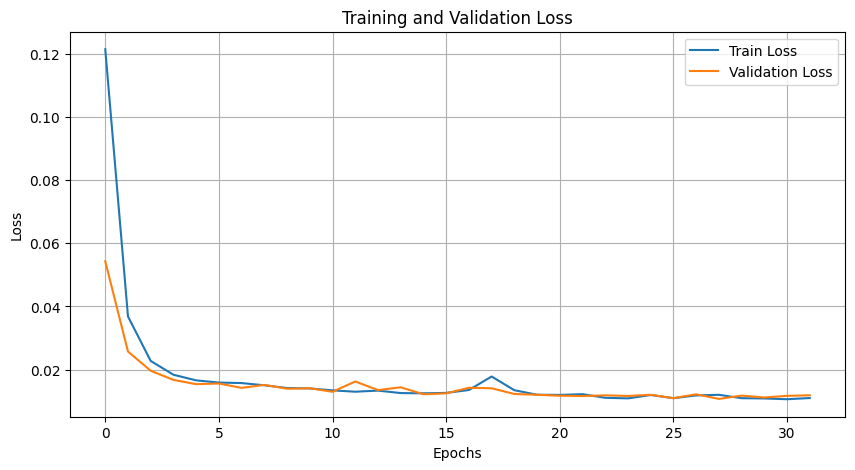

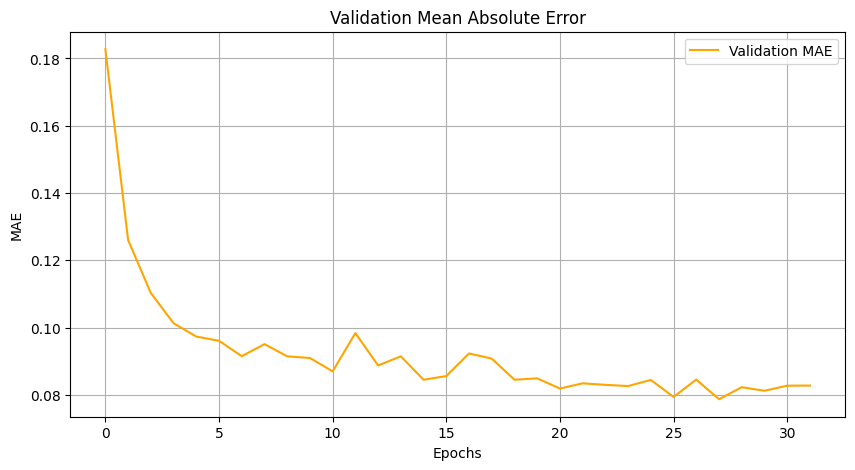

In [40]:
# Extract metrics from the history
epochs = range(len(history))
train_loss = [result['train_loss'] for result in history]
val_loss = [result['val_loss'] for result in history]
val_mae = [result['val_mae'] for result in history]

# Plot train_loss and val_loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot val_mae
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_mae, label='Validation MAE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Validation Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# testing with other episodes
test_ds = DoorDataset(episodes[1])
test_obs, test_actions = test_ds[6]
xb = test_obs.unsqueeze(0) # since model expects as batch, we give it as a batch size = 1
yb = model(xb)
print("Mean absolute error: {:.4f}".format(f.mse_loss(yb, test_actions.unsqueeze(0))))
print("Cool bruh!")

Mean absolute error: 0.0145
Cool bruh!
